In [ ]:
import pandas as pd
import numpy as np

import ast

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from scipy.sparse import lil_matrix

import re

In [2]:
# read data
df = pd.read_csv('../data/twitter/processed.csv')
df['processed_text'] = df['processed_text'].apply(lambda x: ast.literal_eval(x))
tokenized_sentences = list(df['processed_text'])

In [3]:
def create_co_matrix(vocab: dict, window_size: int, tokenized_sentences: list):
    vocab_size = len(vocab)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

    for sentence in tokenized_sentences:
        sentence_length = len(sentence)
        for idx, word in enumerate(sentence):
            word_idx = vocab[word]
            
            # Define the context window
            start = max(0, idx - window_size)
            end = min(sentence_length, idx + window_size + 1)
            
            # Update co-occurrence counts for words in the window
            for context_idx in range(start, end):
                if idx != context_idx:  # Skip the word itself
                    context_word_idx = vocab[sentence[context_idx]]
                    co_matrix[word_idx, context_word_idx] += 1

    return co_matrix

def create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, k):
    sppmi_matrix = np.zeros_like(co_matrix)
    
    # Find indices where co_matrix > 0
    rows, cols = np.nonzero(co_matrix)

    for i, j in zip(rows, cols):
        pmi = np.log((co_matrix[i, j] * co_occurrence_sum) / (word_occurrences[i] * word_occurrences[j]))
        sppmi = pmi - np.log(k)
        sppmi_matrix[i, j] = max(sppmi, 0)  # SPPMI

    return sppmi_matrix

In [4]:
vocab = {
    word: idx for idx, word in enumerate(set(word for sentence in tokenized_sentences for word in sentence))
}

In [5]:
dimensions = [128, 256] # dimension vectors of svd
window_sizes = [2, 5]
ks = [5, 10] # for SPPMI

svd_models = {}
sppmi_embeddings = {}

for d in dimensions:
    for w in window_sizes:
        for k in ks:
            co_matrix = create_co_matrix(vocab, w, tokenized_sentences)
            co_occurrence_sum = np.sum(co_matrix)
            word_occurrences = np.sum(co_matrix, axis=1)
            
            # create sppmi matrix
            sppmi_matrix = create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, k)

            # fit svd
            print(f'Fitting SVD model with dimensions = {d}, window size = {w}, k = {k}')
            
            svd = TruncatedSVD(n_components=d)
            U_k = svd.fit_transform(sppmi_matrix)
            Sigma_k = np.diag(svd.singular_values_)
            Sigma_k_sqrt = np.sqrt(Sigma_k)
            sppmi_embedding = U_k @ Sigma_k_sqrt

            # save model in dictionary
            svd_models[(d, w, k)] = svd

            # save embeddings in dictionary
            sppmi_embeddings[(d, w, k)] = sppmi_embedding

Fitting SVD model with dimensions = 128, window size = 2, k = 5
Fitting SVD model with dimensions = 128, window size = 2, k = 10
Fitting SVD model with dimensions = 128, window size = 5, k = 5
Fitting SVD model with dimensions = 128, window size = 5, k = 10
Fitting SVD model with dimensions = 256, window size = 2, k = 5
Fitting SVD model with dimensions = 256, window size = 2, k = 10
Fitting SVD model with dimensions = 256, window size = 5, k = 5
Fitting SVD model with dimensions = 256, window size = 5, k = 10


## Analysis

### Nearest Neighbours for selected words

In [6]:
word_to_index = vocab
index_to_word = {idx: word for word, idx in vocab.items()}

def get_similar_words(word, embeddings, top_k=10):
    idx = word_to_index[word]
    vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(vec, embeddings)[0]
    # Get top_n indices (excluding the word itself)
    top_indices = np.argsort(-sims)[1:top_k + 1]
    return [(index_to_word[i], sims[i]) for i in top_indices]

In [11]:
selected_words = [
    'sad',
    'chocolate',
    'chemistry',
    'month',
    'news'
]

for key, sppmi_embedding in sppmi_embeddings.items():
    dim, window, k = key
    print(f'Embeddings of SVD model with dimensions = {dim}, window = {window}, k = {k}')
    for word in selected_words:
        print(f"Similar words to '{word}':")
        print(get_similar_words(word, sppmi_embedding))
        print("*" * 30)
    print("-" * 50)

Embeddings of SVD model with dimensions = 128, window = 2, k = 5
Similar words to 'sad':
[('incredibly', 0.71232116), ('httpplurkcomp11w5oz', 0.66254294), ('natalietejeda', 0.63485587), ('joe19g27', 0.6020003), ('cemburuuu', 0.5853363), ('tt', 0.5824352), ('annoyed', 0.56947076), ('hard', 0.55576724), ('super', 0.55407697), ('singing', 0.54948556)]
******************************
Similar words to 'chocolate':
[('superaddict', 0.81103694), ('dagoba', 0.779592), ('helloo', 0.67864007), ('ice', 0.66329736), ('peroniâ', 0.65877354), ('cream', 0.6583879), ('antihumidity', 0.6558567), ('ate', 0.64575577), ('coneno', 0.6338211), ('milk', 0.6142405)]
******************************
Similar words to 'chemistry':
[('desperate', 0.60239863), ('thedebbyryan', 0.6014647), ('gasp', 0.5929564), ('kumbayah', 0.5755825), ('dprss', 0.56463176), ('fyi', 0.5599688), ('chemistrybaaahh', 0.55715317), ('jammie', 0.54961336), ('rm', 0.5359745), ('calm', 0.53349924)]
******************************
Similar words 

Best SPPMI-SVD model is dimensions = 128, window = 5, k = 5, based on qualitative evaluation of word similarities

### Visualization of embedding space

In [12]:
sppmi_embedding = sppmi_embeddings[(128, 5, 5)]

In [13]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sppmi_embedding)

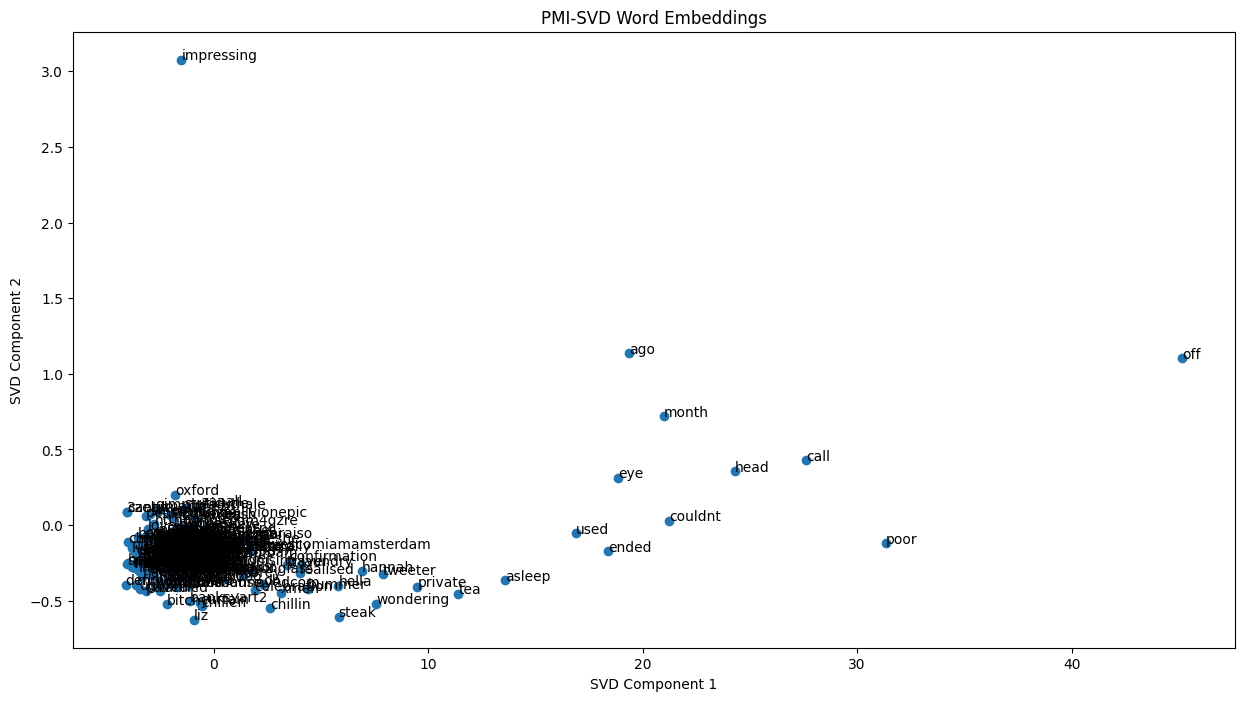

In [16]:
words = list(vocab.keys())[:200]

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:200, 0], reduced_embeddings[:200, 1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("PMI-SVD Word Embeddings")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()

Most words cluster together, except a few words that are spread further apart. This signals poor performance of the SPPMI-SVD model